In [375]:
#wuhuu 1.93 kaldi 0.30 gelistirme
#yapilacaklardan bazilari -- lat lon verilerini en yakin bes sehiri isaretleme
#lag olarak son dort gunun verilerini girme (elektrik aletlerin de bi direnme durumu var eger hava 4 gun ust uste cok sogursa bunu model bilmeli)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np



In [376]:
def aggregate_weather_data(daily_weather):
        
        daily_weather['tarih'] = pd.to_datetime(daily_weather['tarih'])
        daily_weather['day'] = daily_weather['tarih'].dt.date
        daily_weather['hour'] = daily_weather['tarih'].dt.hour


        daily_weather = daily_weather.groupby(['ilce', pd.Grouper(freq='D', key='tarih')])
        ## Apply the aggregations
        daily_weather= daily_weather.agg({
            't_2m:C': ['max', 'min', 'mean','std'],  # temperature
            'prob_precip_1h:p': ['sum', 'max' ,'mean'],  # precipitation
            'wind_speed_10m:ms': ['max', 'mean','std'],  # wind speed
            'wind_dir_10m:d': 'mean',  # wind direction
            'global_rad:W': 'sum',  # sunshine duration
            'effective_cloud_cover:p': ['mean','std'],  # cloud cover
            'relative_humidity_2m:p': ['max', 'min', 'mean']  # humidity
        }) 
        daily_weather.columns = ['_'.join(col).strip() for col in daily_weather.columns.values]
        daily_weather= daily_weather.reset_index() 


        # Add features
        daily_weather['thunderstorm'] = (daily_weather['prob_precip_1h:p_sum'] > 0.5) & (daily_weather['wind_speed_10m:ms_max'] > 10)
        daily_weather['hurricane_typhoon'] = (daily_weather['wind_speed_10m:ms_max'] > 50) & (daily_weather['prob_precip_1h:p_sum'] > 0.5)
        daily_weather['ice_snow'] = (daily_weather['t_2m:C_min'] < 0) & (daily_weather['prob_precip_1h:p_sum'] > 0.5)
        daily_weather['heatwave'] = (daily_weather['t_2m:C_max'] > 30) & (daily_weather['relative_humidity_2m:p_max'] > 0.5)
        daily_weather['flooding'] = (daily_weather['prob_precip_1h:p_sum'] > 0.8) & (daily_weather['global_rad:W_sum'] < 100)
        daily_weather['wildfire'] = (daily_weather['t_2m:C_max'] > 25) & (daily_weather['relative_humidity_2m:p_min'] < 0.2)
        daily_weather['tornado'] = (daily_weather['wind_speed_10m:ms_max'] > 30) & (daily_weather['prob_precip_1h:p_sum'] > 0.5)


        # Flatten the MultiIndex columns
        return daily_weather
def create_unique_id(df):
    df['unique_id'] = df['tarih'].astype(str) +  '-' +df['ilce'].astype(str) 
    return df


In [377]:
from datetime import datetime
train= pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")
weather = pd.read_csv("weather.csv")
holidays = pd.read_csv("holidays.csv")

# "date" sütununu "tarih" olarak değiştirme
weather.rename(columns={"date": "tarih"}, inplace=True)
weather.rename(columns={"name": "ilce"}, inplace=True)


citylatlong = weather[['ilce', 'lat', 'lon']]
citylatlong

,ilce,lat,lon
0,Manisa-Ahmetli,38.6184,28.6712
1,Manisa-Ahmetli,38.6184,28.6712
2,Manisa-Ahmetli,38.6184,28.6712
3,Manisa-Ahmetli,38.6184,28.6712
4,Manisa-Ahmetli,38.6184,28.6712
...,...,...,...
1302835,Izmir-Odemis,38.2283,27.9748
1302836,Izmir-Odemis,38.2283,27.9748
1302837,Izmir-Odemis,38.2283,27.9748
1302838,Izmir-Odemis,38.2283,27.9748


In [378]:

# Tüm ilçe isimlerini küçük harfe dönüştür
weather["ilce"] = weather["ilce"].str.lower()
train["ilce"] = train["ilce"].str.lower()
test["ilce"] = test["ilce"].str.lower()

print(len(test))
print(len(train))





1363
48148


In [379]:
holidays = pd.read_csv('holidays.csv')
holidays.columns =['year', 'month' ,'day' , 'holiday']
add_columns = holidays['holiday']
# Create a new column for each unique holiday name

holidays['tarih'] = pd.to_datetime(holidays[['year', 'month', 'day']])
for new in holidays['holiday'].unique():
    holidays[new] = (holidays['holiday'] == new).astype(int)
holidays.drop(['holiday', 'year', 'month', 'day'] , axis=1 , inplace=True)
holidays.columns
holidays.tail()


,tarih,New Year's Day,National Sovereignty and Children's Day,Labour Day,"Commemoration of Ataturk, Youth and Sports Day",Democracy and National Unity Day,Victory Day,Republic Day,Ramadan Feast* (*estimated),Ramadan Feast Holiday* (*estimated),Sacrifice Feast* (*estimated),Sacrifice Feast Holiday* (*estimated),National Sovereignty and Children's Day; Ramadan Feast Holiday* (*estimated)
50,2024-04-12,0,0,0,0,0,0,0,0,1,0,0,0
51,2024-06-16,0,0,0,0,0,0,0,0,0,1,0,0
52,2024-06-17,0,0,0,0,0,0,0,0,0,0,1,0
53,2024-06-18,0,0,0,0,0,0,0,0,0,0,1,0
54,2024-06-19,0,0,0,0,0,0,0,0,0,0,1,0


In [355]:
weather.rename(columns={'date': 'tarih','name':'ilce'}, inplace=True)
weather = aggregate_weather_data(weather)
#weather = create_unique_id(weather)
#weather['unique_id']
weather

,ilce,tarih,t_2m:C_max,t_2m:C_min,t_2m:C_mean,t_2m:C_std,prob_precip_1h:p_sum,prob_precip_1h:p_max,prob_precip_1h:p_mean,wind_speed_10m:ms_max,...,relative_humidity_2m:p_max,relative_humidity_2m:p_min,relative_humidity_2m:p_mean,thunderstorm,hurricane_typhoon,ice_snow,heatwave,flooding,wildfire,tornado
0,izmir-aliaga,2021-01-01,15.8,11.3,13.275000,1.305923,24.0,1.0,1.000000,6.4,...,91.8,75.7,85.991667,False,False,False,False,False,False,False
1,izmir-aliaga,2021-01-02,17.2,10.6,12.870833,2.377883,24.0,1.0,1.000000,4.0,...,93.7,63.6,82.137500,False,False,False,False,False,False,False
2,izmir-aliaga,2021-01-03,15.9,11.1,12.633333,1.351864,202.3,50.6,8.429167,4.1,...,84.6,73.0,79.120833,False,False,False,False,False,False,False
3,izmir-aliaga,2021-01-04,17.0,11.0,13.733333,2.388317,30.6,3.3,1.275000,6.6,...,84.1,59.3,70.312500,False,False,False,False,False,False,False
4,izmir-aliaga,2021-01-05,16.8,12.2,14.375000,1.522655,257.3,94.9,10.720833,7.8,...,95.2,55.6,75.220833,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54280,manisa-yunusemre,2024-02-25,19.5,9.3,13.137500,3.389730,41.1,18.1,1.712500,1.2,...,94.6,47.8,72.233333,False,False,False,False,False,False,False
54281,manisa-yunusemre,2024-02-26,18.4,9.7,13.041667,2.537873,232.3,42.0,9.679167,1.4,...,90.1,48.6,68.458333,False,False,False,False,False,False,False
54282,manisa-yunusemre,2024-02-27,20.0,10.6,14.216667,3.024202,24.0,1.0,1.000000,2.6,...,100.0,48.7,79.141667,False,False,False,False,False,False,False
54283,manisa-yunusemre,2024-02-28,20.6,10.1,14.195833,3.844078,24.0,1.0,1.000000,1.5,...,100.0,51.1,77.558333,False,False,False,False,False,False,False


In [356]:
weather

,ilce,tarih,t_2m:C_max,t_2m:C_min,t_2m:C_mean,t_2m:C_std,prob_precip_1h:p_sum,prob_precip_1h:p_max,prob_precip_1h:p_mean,wind_speed_10m:ms_max,...,relative_humidity_2m:p_max,relative_humidity_2m:p_min,relative_humidity_2m:p_mean,thunderstorm,hurricane_typhoon,ice_snow,heatwave,flooding,wildfire,tornado
0,izmir-aliaga,2021-01-01,15.8,11.3,13.275000,1.305923,24.0,1.0,1.000000,6.4,...,91.8,75.7,85.991667,False,False,False,False,False,False,False
1,izmir-aliaga,2021-01-02,17.2,10.6,12.870833,2.377883,24.0,1.0,1.000000,4.0,...,93.7,63.6,82.137500,False,False,False,False,False,False,False
2,izmir-aliaga,2021-01-03,15.9,11.1,12.633333,1.351864,202.3,50.6,8.429167,4.1,...,84.6,73.0,79.120833,False,False,False,False,False,False,False
3,izmir-aliaga,2021-01-04,17.0,11.0,13.733333,2.388317,30.6,3.3,1.275000,6.6,...,84.1,59.3,70.312500,False,False,False,False,False,False,False
4,izmir-aliaga,2021-01-05,16.8,12.2,14.375000,1.522655,257.3,94.9,10.720833,7.8,...,95.2,55.6,75.220833,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54280,manisa-yunusemre,2024-02-25,19.5,9.3,13.137500,3.389730,41.1,18.1,1.712500,1.2,...,94.6,47.8,72.233333,False,False,False,False,False,False,False
54281,manisa-yunusemre,2024-02-26,18.4,9.7,13.041667,2.537873,232.3,42.0,9.679167,1.4,...,90.1,48.6,68.458333,False,False,False,False,False,False,False
54282,manisa-yunusemre,2024-02-27,20.0,10.6,14.216667,3.024202,24.0,1.0,1.000000,2.6,...,100.0,48.7,79.141667,False,False,False,False,False,False,False
54283,manisa-yunusemre,2024-02-28,20.6,10.1,14.195833,3.844078,24.0,1.0,1.000000,1.5,...,100.0,51.1,77.558333,False,False,False,False,False,False,False


In [357]:

after_date = datetime(2024, 2, 1)
# train data buraya baslangictan 2024/2/01'a kadar olacak
weather_train = weather[weather['tarih'] < after_date]
holidays_train = holidays[holidays['tarih'] < after_date]

# test data buraya sadece asagidaki tarihten itibaren olacak
weather_test = weather[weather['tarih'] >= after_date ]
holidays_test = holidays[holidays['tarih'] >= after_date]
len(weather_test)


1363

In [358]:
#ARADA BOSLUK GUNLER VAR ONLARI MEAN ILE DOLDURDUK SORUN OLABILIR TABI AMA OLSUN
from sklearn.impute import SimpleImputer


columns_to_impute = ['bildirimsiz_sum', 'bildirimli_sum']

# Create a simple imputer
imputer = SimpleImputer(strategy='mean')

# Fit the imputer to the data
imputer.fit(train[columns_to_impute])

# Impute the missing values
train[columns_to_impute] = imputer.transform(train[columns_to_impute])
train.tail()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum
48143,2024-01-23,manisa-ahmetli,1.0,0.0
48144,2024-01-24,manisa-ahmetli,2.0,0.0
48145,2024-01-25,manisa-ahmetli,2.0,0.0
48146,2024-01-26,manisa-ahmetli,2.0,0.0
48147,2024-01-29,manisa-ahmetli,0.0,1.0


In [359]:
train.columns = ['tarih' , 'ilce' , 'bildirimsiz_sum', 'bildirimli_sum']
#train = create_unique_id(train)
train['tarih'] = pd.to_datetime(train['tarih'])
 #Process data and train model
train

,tarih,ilce,bildirimsiz_sum,bildirimli_sum
0,2021-01-01,izmir-aliaga,5.0,0.0
1,2021-01-02,izmir-aliaga,13.0,0.0
2,2021-01-03,izmir-aliaga,4.0,0.0
3,2021-01-04,izmir-aliaga,9.0,0.0
4,2021-01-05,izmir-aliaga,2.0,0.0
...,...,...,...,...
48143,2024-01-23,manisa-ahmetli,1.0,0.0
48144,2024-01-24,manisa-ahmetli,2.0,0.0
48145,2024-01-25,manisa-ahmetli,2.0,0.0
48146,2024-01-26,manisa-ahmetli,2.0,0.0


In [360]:
test.columns= ['tarih','ilce','bildirimli_sum']
#test = create_unique_id(test)
test.head()
print(len(test))

1363


In [361]:

sample_submission.tail()

,unique_id,bildirimsiz_sum
1358,2024-02-29-izmir-beydag,NaN
1359,2024-02-29-izmir-narlidere,NaN
1360,2024-02-29-izmir-selcuk,NaN
1361,2024-02-29-manisa-kula,NaN
1362,2024-02-29-manisa-ahmetli,NaN


In [362]:
train.sample()

,tarih,ilce,bildirimsiz_sum,bildirimli_sum
1751,2022-10-11,izmir-bayindir,7.0,3.0


In [363]:
##@@@ test ops train ops
test['tarih'] = pd.to_datetime(test['tarih'])

test['days_in_month'] = test['tarih'].dt.days_in_month
test['days_in_year'] = test['tarih'].dt.day_of_year
test['days_in_week'] = test['tarih'].dt.weekday
test['month'] = test['tarih'].dt.month
test['year'] = test['tarih'].dt.year

train['tarih'] = pd.to_datetime(train['tarih'])

train['days_in_month'] = train['tarih'].dt.days_in_month
train['days_in_year'] = train['tarih'].dt.day_of_year
train['days_in_week'] = train['tarih'].dt.weekday
train['month'] = train['tarih'].dt.month
train['year'] = train['tarih'].dt.year


# Tarih sütunlarının formatlarını uygun hale getir
weather["tarih"] = pd.to_datetime(weather["tarih"])
train["tarih"] = pd.to_datetime(train["tarih"])
test["tarih"] = pd.to_datetime(test["tarih"])
max(test['tarih'])
len(test)

1363

In [364]:
from sklearn.calibration import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train['ilce'])
# Transform both datasets using the same encoder
train['ilce-value'] = label_encoder.transform(train['ilce'])
test['ilce-value'] = label_encoder.transform(test['ilce'])


In [365]:
# Set ilce and tarih as the index
test.set_index(['ilce', 'tarih'], inplace=True)
weather_test.set_index(['ilce', 'tarih'], inplace=True)
train.set_index(['ilce', 'tarih'], inplace=True)
weather_train.set_index(['ilce', 'tarih'], inplace=True)





In [366]:

# Merge the dataframes
test_df = pd.merge(test, weather_test, on=['ilce', 'tarih'])
train_df = pd.merge(train, weather_train, on=['ilce', 'tarih'])
train_df = pd.merge(train, weather_train, left_index=True, right_index=True)
len(test_df)
test_df.columns

Index(['bildirimli_sum', 'days_in_month', 'days_in_year', 'days_in_week',
       'month', 'year', 'ilce-value', 't_2m:C_max', 't_2m:C_min',
       't_2m:C_mean', 't_2m:C_std', 'prob_precip_1h:p_sum',
       'prob_precip_1h:p_max', 'prob_precip_1h:p_mean',
       'wind_speed_10m:ms_max', 'wind_speed_10m:ms_mean',
       'wind_speed_10m:ms_std', 'wind_dir_10m:d_mean', 'global_rad:W_sum',
       'effective_cloud_cover:p_mean', 'effective_cloud_cover:p_std',
       'relative_humidity_2m:p_max', 'relative_humidity_2m:p_min',
       'relative_humidity_2m:p_mean', 'thunderstorm', 'hurricane_typhoon',
       'ice_snow', 'heatwave', 'flooding', 'wildfire', 'tornado'],
      dtype='object')

Creating Weather data and merging them into train data 

In [367]:
train_index_values = train_df.index.get_level_values('tarih')
train_df['tarih-value'] = pd.factorize(train_index_values)[0]
max_train_tarih = max(train_df['tarih-value'])

test_index_values = test_df.index.get_level_values('tarih')
test_df['tarih-value'] = pd.factorize(test_index_values)[0] + max_train_tarih + 1

test_df

,,bildirimli_sum,days_in_month,days_in_year,days_in_week,month,year,ilce-value,t_2m:C_max,t_2m:C_min,t_2m:C_mean,...,relative_humidity_2m:p_min,relative_humidity_2m:p_mean,thunderstorm,hurricane_typhoon,ice_snow,heatwave,flooding,wildfire,tornado,tarih-value
ilce,tarih,,,,,,,,,,,,,,,,,,,,,
izmir-aliaga,2024-02-01,0,29,32,3,2,2024,0,12.0,5.0,7.616667,...,49.9,72.116667,False,False,False,False,False,False,False,1126
izmir-bayindir,2024-02-01,1,29,32,3,2,2024,2,12.6,2.9,6.429167,...,52.2,77.904167,False,False,False,False,False,False,False,1126
izmir-bayrakli,2024-02-01,0,29,32,3,2,2024,3,12.0,3.9,6.954167,...,49.8,76.537500,False,False,False,False,False,False,False,1126
izmir-bergama,2024-02-01,1,29,32,3,2,2024,4,11.4,2.8,6.575000,...,51.5,73.729167,False,False,False,False,False,False,False,1126
izmir-bornova,2024-02-01,1,29,32,3,2,2024,6,11.3,2.9,6.054167,...,50.1,79.058333,False,False,False,False,False,False,False,1126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
izmir-beydag,2024-02-29,0,29,60,3,2,2024,5,22.6,8.7,15.387500,...,32.8,64.316667,False,False,False,False,False,False,False,1154
izmir-narlidere,2024-02-29,0,29,60,3,2,2024,23,21.2,12.6,16.283333,...,45.3,68.395833,False,False,False,False,False,False,False,1154
izmir-selcuk,2024-02-29,0,29,60,3,2,2024,26,23.2,8.8,15.429167,...,39.0,69.895833,False,False,False,False,False,False,False,1154


In [368]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# Hedef değişkeni ve özellikleri ayır
X = train_df.drop(columns=["bildirimsiz_sum"])
y = train_df["bildirimsiz_sum"]

corr = train_df.corr()
target_corr = abs(corr["bildirimsiz_sum"])
corr_threshold = 0.02
high_corr_features = target_corr[target_corr > corr_threshold]
# özellik isimlerini alalım ve bildirimsiz_sum özelliğini çıkaralım
hcf_names = [k for k, v in high_corr_features.items()]; hcf_names.remove("bildirimsiz_sum")
#print(hcf_names)
features= ['bildirimli_sum', 'days_in_month', 'days_in_year',
       'days_in_week', 'month', 'year', 't_2m:C_max', 't_2m:C_min',
       't_2m:C_mean', 't_2m:C_std', 'prob_precip_1h:p_sum',
       'prob_precip_1h:p_max', 'prob_precip_1h:p_mean',
       'wind_speed_10m:ms_max', 'wind_speed_10m:ms_mean',
       'wind_speed_10m:ms_std', 'wind_dir_10m:d_mean', 'global_rad:W_sum',
       'effective_cloud_cover:p_mean', 'effective_cloud_cover:p_std',
       'relative_humidity_2m:p_max', 'relative_humidity_2m:p_min',
       'relative_humidity_2m:p_mean', 'tarih-value', 'ilce-value','thunderstorm', 'hurricane_typhoon',
       'ice_snow', 'heatwave', 'flooding', 'wildfire', 'tornado']


In [369]:
test_df.columns




Index(['bildirimli_sum', 'days_in_month', 'days_in_year', 'days_in_week',
       'month', 'year', 'ilce-value', 't_2m:C_max', 't_2m:C_min',
       't_2m:C_mean', 't_2m:C_std', 'prob_precip_1h:p_sum',
       'prob_precip_1h:p_max', 'prob_precip_1h:p_mean',
       'wind_speed_10m:ms_max', 'wind_speed_10m:ms_mean',
       'wind_speed_10m:ms_std', 'wind_dir_10m:d_mean', 'global_rad:W_sum',
       'effective_cloud_cover:p_mean', 'effective_cloud_cover:p_std',
       'relative_humidity_2m:p_max', 'relative_humidity_2m:p_min',
       'relative_humidity_2m:p_mean', 'thunderstorm', 'hurricane_typhoon',
       'ice_snow', 'heatwave', 'flooding', 'wildfire', 'tornado',
       'tarih-value'],
      dtype='object')

In [370]:
X_test = test_df[features]
X_test

,,bildirimli_sum,days_in_month,days_in_year,days_in_week,month,year,t_2m:C_max,t_2m:C_min,t_2m:C_mean,t_2m:C_std,...,relative_humidity_2m:p_mean,tarih-value,ilce-value,thunderstorm,hurricane_typhoon,ice_snow,heatwave,flooding,wildfire,tornado
ilce,tarih,,,,,,,,,,,,,,,,,,,,,
izmir-aliaga,2024-02-01,0,29,32,3,2,2024,12.0,5.0,7.616667,2.474156,...,72.116667,1126,0,False,False,False,False,False,False,False
izmir-bayindir,2024-02-01,1,29,32,3,2,2024,12.6,2.9,6.429167,3.455491,...,77.904167,1126,2,False,False,False,False,False,False,False
izmir-bayrakli,2024-02-01,0,29,32,3,2,2024,12.0,3.9,6.954167,2.861738,...,76.537500,1126,3,False,False,False,False,False,False,False
izmir-bergama,2024-02-01,1,29,32,3,2,2024,11.4,2.8,6.575000,2.612387,...,73.729167,1126,4,False,False,False,False,False,False,False
izmir-bornova,2024-02-01,1,29,32,3,2,2024,11.3,2.9,6.054167,2.982263,...,79.058333,1126,6,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
izmir-beydag,2024-02-29,0,29,60,3,2,2024,22.6,8.7,15.387500,4.698040,...,64.316667,1154,5,False,False,False,False,False,False,False
izmir-narlidere,2024-02-29,0,29,60,3,2,2024,21.2,12.6,16.283333,3.040547,...,68.395833,1154,23,False,False,False,False,False,False,False
izmir-selcuk,2024-02-29,0,29,60,3,2,2024,23.2,8.8,15.429167,5.090783,...,69.895833,1154,26,False,False,False,False,False,False,False


In [371]:
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.6, 1.0],
    'gamma': [0, 0.1, 0.3]
}

# Model oluşturma
xgb = XGBRegressor()

# GridSearchCV ile en iyi parametre kombinasyonunun bulunması
#grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
#grid_search.fit(X,y)
#njobs -1 olmali (benim makinem paralel calismiyor cunku )
# En iyi parametrelerin bulunması
#best_params = grid_search.best_params_

#eski 1.bestparams = learningrate : 0.01 maxdepth 10 yenisi asagida
best_params = {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 50, 'subsample': 0.8}
print("En iyi parametreler:", best_params)


En iyi parametreler: {'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.005, 'max_depth': 15, 'n_estimators': 50, 'subsample': 0.8}


In [372]:

# XGBoost modelini eğitme
xgboost_model = XGBRegressor(**best_params)
xgboost_model.fit(train_df[features],y)

# CatBoost modelini eğitme
catboost_model = CatBoostRegressor()
catboost_model.fit(train_df[features],y)

# Tahminler yapma



X_test = test_df[features]
X_test


Learning rate set to 0.075514
0:	learn: 5.3884835	total: 5.85ms	remaining: 5.84s
1:	learn: 5.3615608	total: 11.1ms	remaining: 5.54s
2:	learn: 5.3340289	total: 16ms	remaining: 5.32s
3:	learn: 5.3037645	total: 20.4ms	remaining: 5.08s
4:	learn: 5.2790924	total: 25.5ms	remaining: 5.07s
5:	learn: 5.2529762	total: 30.1ms	remaining: 4.99s
6:	learn: 5.2221514	total: 34.3ms	remaining: 4.86s
7:	learn: 5.2050970	total: 38.8ms	remaining: 4.81s
8:	learn: 5.1859091	total: 42.7ms	remaining: 4.7s
9:	learn: 5.1682462	total: 46.5ms	remaining: 4.6s
10:	learn: 5.1542008	total: 50.6ms	remaining: 4.55s
11:	learn: 5.1408283	total: 54.8ms	remaining: 4.51s
12:	learn: 5.1243879	total: 59.1ms	remaining: 4.49s
13:	learn: 5.1134852	total: 62.9ms	remaining: 4.43s
14:	learn: 5.0926387	total: 66.8ms	remaining: 4.39s
15:	learn: 5.0744668	total: 71ms	remaining: 4.36s
16:	learn: 5.0642133	total: 75.1ms	remaining: 4.34s
17:	learn: 5.0562698	total: 79.5ms	remaining: 4.33s
18:	learn: 5.0400752	total: 83.7ms	remaining: 4.32

,,bildirimli_sum,days_in_month,days_in_year,days_in_week,month,year,t_2m:C_max,t_2m:C_min,t_2m:C_mean,t_2m:C_std,...,relative_humidity_2m:p_mean,tarih-value,ilce-value,thunderstorm,hurricane_typhoon,ice_snow,heatwave,flooding,wildfire,tornado
ilce,tarih,,,,,,,,,,,,,,,,,,,,,
izmir-aliaga,2024-02-01,0,29,32,3,2,2024,12.0,5.0,7.616667,2.474156,...,72.116667,1126,0,False,False,False,False,False,False,False
izmir-bayindir,2024-02-01,1,29,32,3,2,2024,12.6,2.9,6.429167,3.455491,...,77.904167,1126,2,False,False,False,False,False,False,False
izmir-bayrakli,2024-02-01,0,29,32,3,2,2024,12.0,3.9,6.954167,2.861738,...,76.537500,1126,3,False,False,False,False,False,False,False
izmir-bergama,2024-02-01,1,29,32,3,2,2024,11.4,2.8,6.575000,2.612387,...,73.729167,1126,4,False,False,False,False,False,False,False
izmir-bornova,2024-02-01,1,29,32,3,2,2024,11.3,2.9,6.054167,2.982263,...,79.058333,1126,6,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
izmir-beydag,2024-02-29,0,29,60,3,2,2024,22.6,8.7,15.387500,4.698040,...,64.316667,1154,5,False,False,False,False,False,False,False
izmir-narlidere,2024-02-29,0,29,60,3,2,2024,21.2,12.6,16.283333,3.040547,...,68.395833,1154,23,False,False,False,False,False,False,False
izmir-selcuk,2024-02-29,0,29,60,3,2,2024,23.2,8.8,15.429167,5.090783,...,69.895833,1154,26,False,False,False,False,False,False,False


In [373]:
print(len(test_df))

1363


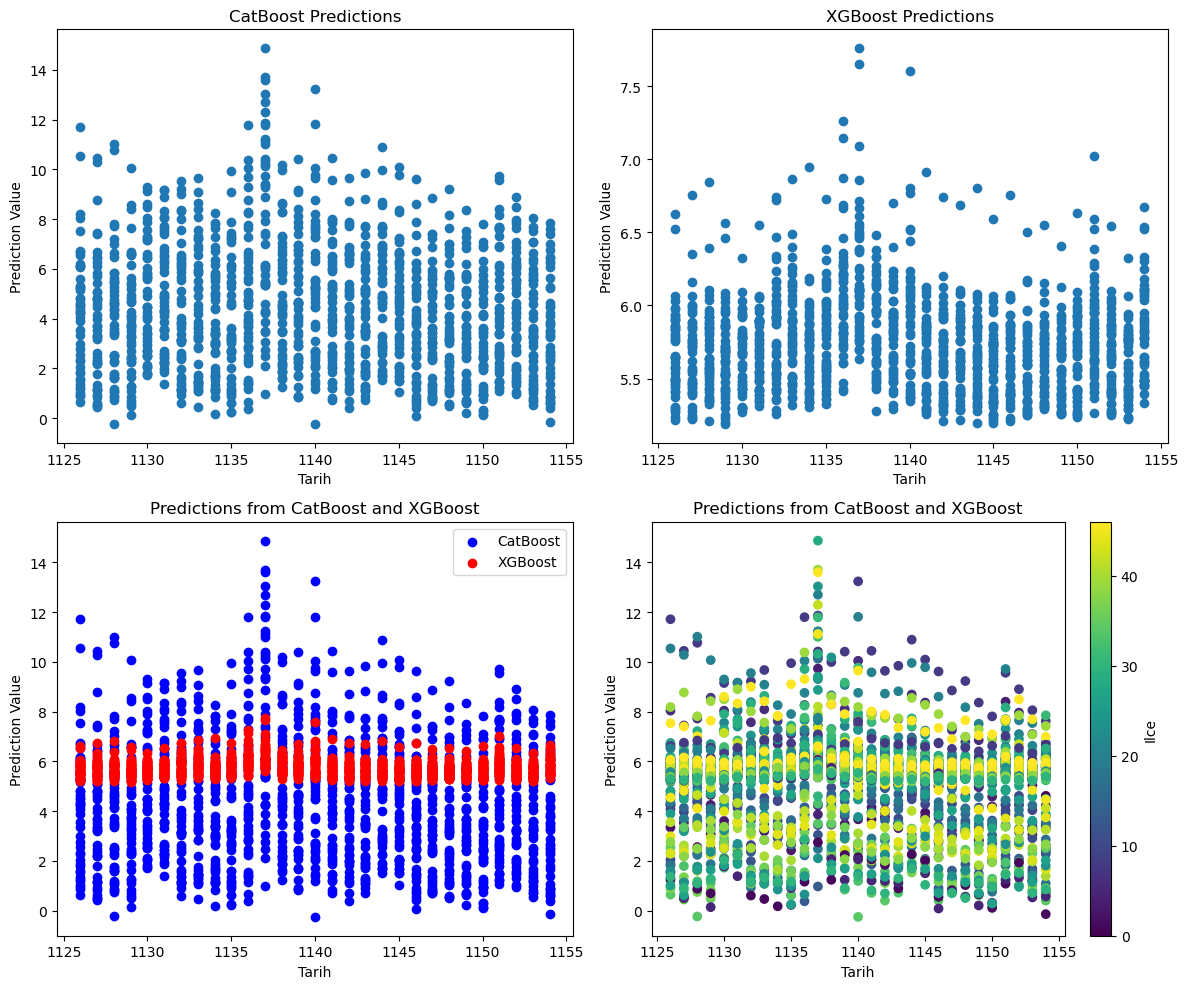

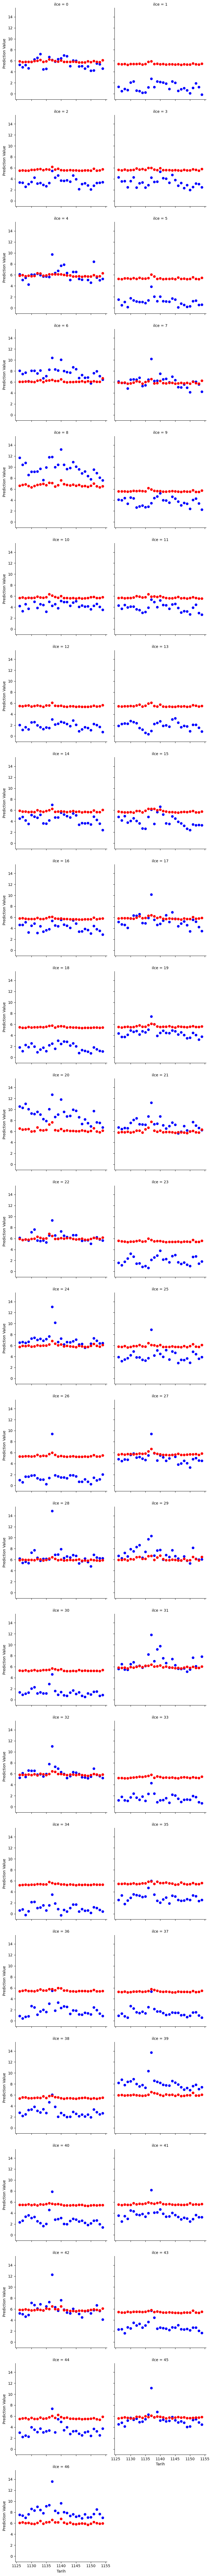

In [374]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming catboost_preds and xgboost_preds are your predictions
# and X_test is your test data
xgboost_preds = xgboost_model.predict(X_test)
catboost_preds = catboost_model.predict(X_test)

# Create a DataFrame to store the predictions
df = pd.DataFrame({'tarih': X_test['tarih-value'], 'ilce': X_test['ilce-value'], 'CatBoost': catboost_preds, 'XGBoost': xgboost_preds})

# Create a figure and axis
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Separate plots for each model
ax[0, 0].scatter(df['tarih'], df['CatBoost'], label='CatBoost')
ax[0, 0].set_title('CatBoost Predictions')
ax[0, 0].set_xlabel('Tarih')
ax[0, 0].set_ylabel('Prediction Value')

ax[0, 1].scatter(df['tarih'], df['XGBoost'], label='XGBoost')
ax[0, 1].set_title('XGBoost Predictions')
ax[0, 1].set_xlabel('Tarih')
ax[0, 1].set_ylabel('Prediction Value')

# Plot 2: Different colors for each model
ax[1, 0].scatter(df['tarih'], df['CatBoost'], label='CatBoost', color='blue')
ax[1, 0].scatter(df['tarih'], df['XGBoost'], label='XGBoost', color='red')
ax[1, 0].set_title('Predictions from CatBoost and XGBoost')
ax[1, 0].set_xlabel('Tarih')
ax[1, 0].set_ylabel('Prediction Value')
ax[1, 0].legend()

# Plot 3: Add ilce to the plot
scatter = ax[1, 1].scatter(df['tarih'], df['CatBoost'], c=df['ilce'], label='CatBoost')
ax[1, 1].scatter(df['tarih'], df['XGBoost'], c=df['ilce'], label='XGBoost')
ax[1, 1].set_title('Predictions from CatBoost and XGBoost')
ax[1, 1].set_xlabel('Tarih')
ax[1, 1].set_ylabel('Prediction Value')
cbar = plt.colorbar(scatter)
cbar.set_label('Ilce')

plt.tight_layout()
plt.show()

# Plot 4: FacetGrid
g = sns.FacetGrid(df, col="ilce", col_wrap=2, height=4)
g.map(plt.scatter, "tarih", "CatBoost", color="blue", label="CatBoost")
g.map(plt.scatter, "tarih", "XGBoost", color="red", label="XGBoost")

g.set_axis_labels("Tarih", "Prediction Value")

plt.show()

In [381]:

#ensemble_preds = (catboost_preds + xgboost_preds) / 2
ensemble_preds = catboost_preds
#ensemble_preds=np.round(catboost_preds).astype(np.int8)
# Sample submission dosyasına tahminleri ekleyerek yeni bir dosya oluşturma
submission = sample_submission.copy()
print(ensemble_preds)
submission["bildirimsiz_sum"] = ensemble_preds
submission.to_csv("catboostonly2_submission-emre-8-05-24.csv", index=False)
#model2.py

[5.30679235 3.34624452 4.27244588 ... 2.02444414 2.67014598 0.85515751]
